# calculate feedbacks in MPI $4 \times CO_2$ run

uses feedbacks calculated from kernel method in the code calc-MPI-historical; the output data is then annual averaged

In [2]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
# import cartopy.crs as ccrs

import os,glob,cftime
from scipy import stats
import xarray as xr
import pandas as pd

import pickle

In [3]:
import eof,ols
from data import check
from xradd import *

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [5]:
covar=lambda x,y,v='time': ((x-x.mean(dim=v))*(y-y.mean(dim=v))).mean(dim=v) 
slope=lambda x,y,v='time': covar(x,y)/x.std(dim=v)**2

# global avg. for lat-only dataarray
def gavglat(x):
    ll=np.cos(np.deg2rad(x.lat)).where(x > -999e9)
    x1=(x*ll).sum(dim='lat')/ll.sum(dim='lat')

    return x1

In [6]:
def plotSinLat(datax,ax,**kwargs):
    """plotSinLat(datax): line plot vs. sin(latitude)
    datax is an xarray"""
    
    sca(ax)
    
    xlat=[-80,-50,-30,-15,0,15,30,50,80]
    xloc=[np.sin(np.deg2rad(ii)) for ii in xlat]
    xlab=[str(ii) for ii in xlat]

    plot(np.sin(np.deg2rad(datax.lat)),datax,**kwargs)
    xticks(xloc,xlab)

## load 4xCO2 data for regression calculation

### load conventional feedback fluxes

In [7]:
### load feedback fluxes
a4=[]
for ii in 'early,mid,late'.split(','):
    a4xco2=xr.open_dataset('/sn1/dessler/MPI-feedback/abrupt4xCO2fluxes-clim-{}.nc'.format(ii))
    a4xco2['lat']=np.round(a4xco2.lat,2)
    a4xco2=a4xco2.expand_dims('period')
    a4xco2['period']=[ii]
    a4xco2['time']=range(1,13)
    a4.append(a4xco2)
a4xco2a=xr.merge(a4)

In [8]:
### load CRF fluxes 
a4=[]
for ii in 'early,mid,late'.split(','):
    a4xco2=xr.open_dataset('/sn1/dessler/MPI-feedback/abrupt4xCO2-clim-{}-crf.nc'.format(ii))
    a4xco2['lat']=np.round(a4xco2.lat,2)
    a4xco2=a4xco2.expand_dims('period')
    a4xco2['period']=[ii]
    a4xco2['time']=range(1,13)
    a4.append(a4xco2)
a4xco2b=xr.merge(a4)
a4xco2b=a4xco2b.drop('t500')

In [10]:
## merge the feedback & CRF fluxes
a4xco2=xr.merge([a4xco2a,a4xco2b])

In [11]:
a4xco2=a4xco2.assign(cloud=a4xco2.cloudlw+a4xco2.cloudsw,\
        alltemp=a4xco2.planckRH+a4xco2.lapserateRH,\
        alllw=a4xco2.planckRH+a4xco2.lapserateRH+a4xco2.watervaporRH,
        resid=a4xco2.total-(a4xco2.planckRH+a4xco2.lapserateRH+\
        a4xco2.watervaporRH+a4xco2.albedo+a4xco2.cloudlw+a4xco2.cloudsw))

a4xco2=a4xco2.rename({'rlutcs':'lwcs','rsutcs':'swcs','rlut':'lw','rsut':'sw'})
a4xco2=a4xco2.assign(crfsw=a4xco2.sw-a4xco2.swcs,crflw=a4xco2.lw-a4xco2.lwcs)
a4xco2=a4xco2.assign(crf=a4xco2.crfsw+a4xco2.crflw)
a4xco2=a4xco2.drop('level')

a4xco2

<xarray.Dataset>
Dimensions:       (lat: 45, lon: 90, period: 3, time: 12)
Coordinates:
  * period        (period) object 'early' 'late' 'mid'
  * lon           (lon) float64 0.0 4.0 8.0 12.0 ... 344.0 348.0 352.0 356.0
  * lat           (lat) float64 -90.0 -85.91 -81.82 -77.73 ... 81.82 85.91 90.0
  * time          (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    planck        (period, time, lat, lon) float32 -12.09987 ... -65.41016
    lapserate     (period, time, lat, lon) float32 0.7027996 ... 32.902607
    planckRH      (period, time, lat, lon) float32 -7.93136 ... -53.06774
    lapserateRH   (period, time, lat, lon) float32 0.0052477196 ... 22.843918
    watervapor    (period, time, lat, lon) float64 3.526 3.526 ... 2.279 2.279
    watervaporRH  (period, time, lat, lon) float64 0.05471 0.05471 ... -0.004475
    albedo        (period, time, lat, lon) float32 -0.5067448 -0.5067448 ... 0.0
    cloudsw       (period, time, lat, lon) float64 -0.5446 -0.5446 ... 1.103
    cl

In [12]:
## calculate zonal and global average feedbacks
z4xco2=a4xco2.mean(dim='lon') # zonal average 
g4xco2=gavg(a4xco2) # global average
ts=g4xco2.temperature

pickle.dump([a4xco2,z4xco2,g4xco2],open('4xco2_output.p','wb'))

## global average feedbacks

In [11]:
g4xco2.mean(dim='time')/ts.mean(dim='time')

<xarray.Dataset>
Dimensions:       (period: 3)
Coordinates:
  * period        (period) object 'early' 'late' 'mid'
Data variables:
    planck        (period) float64 -3.219 -3.189 -3.212
    lapserate     (period) float64 -0.7469 -0.5748 -0.7032
    planckRH      (period) float64 -1.842 -1.846 -1.842
    lapserateRH   (period) float64 -0.2157 -0.1397 -0.1931
    watervapor    (period) float64 1.817 1.776 1.837
    watervaporRH  (period) float64 -0.09093 -0.002271 -0.04278
    albedo        (period) float64 0.2669 0.3088 0.2996
    cloudsw       (period) float64 -0.3486 -0.2567 -0.3291
    cloudlw       (period) float64 0.6916 0.6727 0.7067
    total         (period) float64 -1.31 -1.148 -1.235
    temperature   (period) float64 1.0 1.0 1.0
    t500          (period) float64 1.265 1.169 1.239
    tas           (period) float64 1.0 1.0 1.0
    sw            (period) float64 0.05347 0.2019 0.1158
    lw            (period) float64 -1.363 -1.35 -1.351
    swcs          (period) float64 0.5

In [12]:
flab={'planckRH':'planck RH', 'lapserateRH':'lapse rate RH', 'watervaporRH':'$\Delta$RH', 'cloudsw':'SW cloud', 'cloudlw':'LW cloud', 
        'cloud':'cloud', 'albedo':'albedo', 'total':'total','resid':'residual', 'sw':'all-sky SW', 'lw':'all-sky LW', 'swcs':'clear-sky SW',\
        'lwcs':'clear-sky LW', 'crfsw':'SW CRF', 'crflw':'LW CRF', 'crf':'CRF', 'alllw':'planck+LR+$\Delta$RH', 'temperature':'temperature'}

test calculating the feedback by differencing the average of periods at the beginning and end of the run

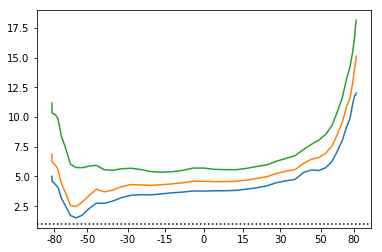

In [14]:
figure()
for ii in 'early,mid,late'.split(','):
    x1=z4xco2.sel(period=ii).temperature.mean(dim='time')
#     x1 /= gavglat(x1)
    plotSinLat(x1,gca())
axhline(1,color='k',ls=':')
# ylim(0,3)

in this version, I use the g4xco2 variable defined above

In [23]:
# actual ECS estimate
print('actual ECS = {:.2f} K'.format(float(ts.sel(period='late').mean()/2)))
print('actual lambda = {:.2f} W/m^2/K'.format(float((g4xco2.total/ts).sel(period='late').mean(dim='time'))))

actual ECS = 3.35 K
actual lambda = -1.14 W/m^2/K


### plot up zonal averages of feedbacks over various time periods

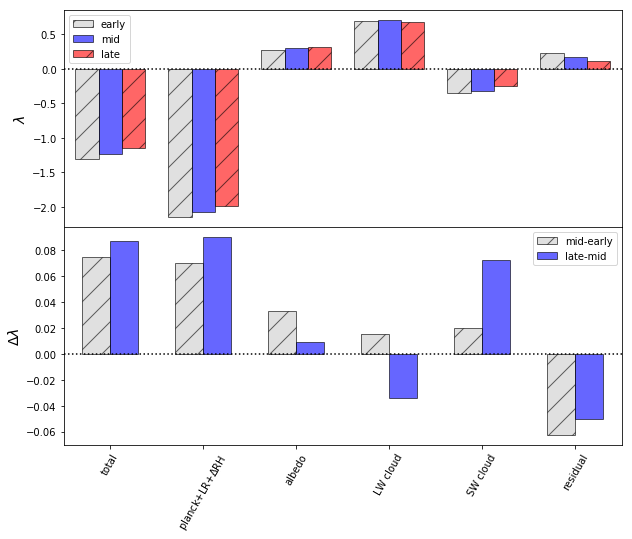

In [97]:
nvarx='total,alllw,albedo,cloudlw,cloudsw,resid'.split(',')
labx=[flab[ii] for ii in nvarx]

fdbk=[]
for tp in 'early,mid,late'.split(','):
    x1=g4xco2.sel(period=tp).mean(dim='time')/ts.sel(period=tp).mean(dim='time')
    fdbk.append(x1)

fig=figure(figsize=(10,8))
plt.subplots_adjust(hspace=0)
ax1=plt.subplot(2,1,1)
sca(ax1)

c1=iter('0.8,b,r,g'.split(','))
h1=iter('/,,/,'.split(','))
labx=iter('early,mid,late'.split(','))

for cnt,f1 in enumerate(fdbk):
    fb=[float(f1[jj]) for jj in nvarx]
    barx=plt.bar(np.arange(0,len(nvarx))+0.25*(cnt-1),fb,alpha=0.6,color=next(c1),hatch=next(h1),edgecolor='black',width=0.25,label=next(labx))

opt={'color':'k','ls':'dotted'}
axhline(0,**opt)

# xticks(range(len(nvarx)),['' for ll in nvarx],rotation=60)
xticks([])

legend()
ylabel('$\lambda$',fontsize=14)
xlim(-0.5,len(nvarx)-0.5)

ax1=plt.subplot(2,1,2)
sca(ax1)

c1=iter('0.8,b,r,g'.split(','))
h1=iter('/,,/,'.split(','))
labx=iter('mid-early,late-mid'.split(','))

for cnt,f1 in enumerate(fdbk[1:]):
    fb=[float(f1[jj]-fdbk[cnt][jj]) for jj in nvarx]
    barx=plt.bar(np.arange(0,len(nvarx))+0.3*(cnt-1)+0.15,fb,alpha=0.6,color=next(c1),hatch=next(h1),edgecolor='black',width=0.3,label=next(labx))

opt={'color':'k','ls':'dotted'}
    
xticks(range(len(nvarx)),[flab[ll] for ll in nvarx],rotation=60)
loc,lab=yticks()
# yticks(loc[:-2])

axhline(0,**opt)

legend()

xlim(-0.5,len(nvarx)-0.5)
ylabel('$\Delta\lambda$',fontsize=14);

Text(0.46,0.9,'(c)')

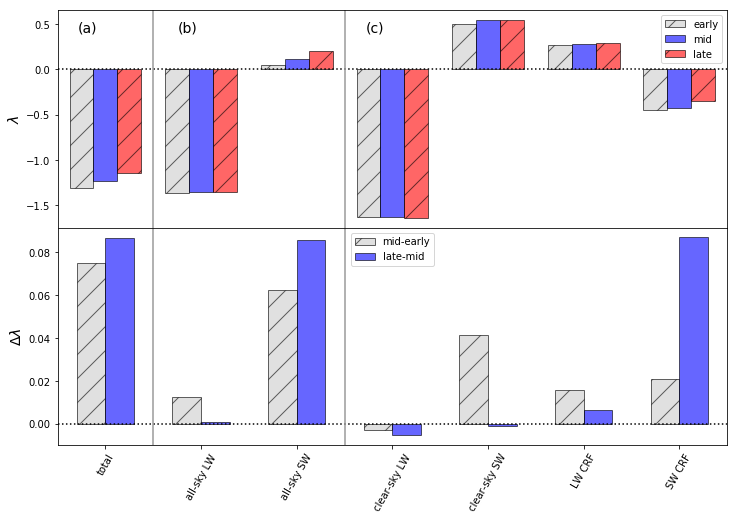

In [104]:
nvarx='total,lw,sw,lwcs,swcs,crflw,crfsw'.split(',')
labx=[flab[ii] for ii in nvarx]

fdbk=[]
for tp in 'early,mid,late'.split(','):
    x1=g4xco2.sel(period=tp).mean(dim='time')/ts.sel(period=tp).mean(dim='time')
    fdbk.append(x1)

fig=figure(figsize=(12,8))
plt.subplots_adjust(hspace=0)
ax1=plt.subplot(2,1,1)
sca(ax1)

c1=iter('0.8,b,r,g'.split(','))
h1=iter('/,,/,'.split(','))
labx=iter('early,mid,late'.split(','))

for cnt,f1 in enumerate(fdbk):
    fb=[float(f1[jj]) for jj in nvarx]
    barx=plt.bar(np.arange(0,len(nvarx))+0.25*(cnt-1),fb,alpha=0.6,color=next(c1),hatch=next(h1),edgecolor='black',width=0.25,label=next(labx))

opt={'color':'k','ls':'dotted'}
axhline(0,**opt)

# xticks(range(len(nvarx)),['' for ll in nvarx],rotation=60)
xticks([])

legend()
ylabel('$\lambda$',fontsize=14)
xlim(-0.5,len(nvarx)-0.5)

ax2=plt.subplot(2,1,2)
sca(ax2)

c1=iter('0.8,b,r,g'.split(','))
h1=iter('/,,/,'.split(','))
labx=iter('mid-early,late-mid'.split(','))

for cnt in range(2):
    fb=[float(fdbk[cnt+1][jj]-fdbk[cnt][jj]) for jj in nvarx]
    barx=plt.bar(np.arange(0,len(nvarx))+0.3*(cnt-1)+0.15,fb,alpha=0.6,color=next(c1),hatch=next(h1),edgecolor='black',width=0.3,label=next(labx))
    
xticks(range(len(nvarx)),[flab[ll] for ll in nvarx],rotation=60)
loc,lab=yticks()
# yticks(loc[:-2])

axhline(0,**opt)

legend()

opt={'color':'0.6','ls':'solid'}
ax1.axvline(0.5,**opt)
ax1.axvline(2.5,**opt)
ax2.axvline(0.5,**opt)
ax2.axvline(2.5,**opt)

xlim(-0.5,len(nvarx)-0.5)
ylabel('$\Delta\lambda$',fontsize=14)

ax1.text(0.03,0.9,'(a)',fontsize=14,transform=ax1.transAxes)
ax1.text(0.18,0.9,'(b)',fontsize=14,transform=ax1.transAxes)
ax1.text(0.46,0.9,'(c)',fontsize=14,transform=ax1.transAxes)

[None, 30] -1.5009971990684743
[30, 150] -1.0643263319574285
[150, 1200] -0.933753959772378


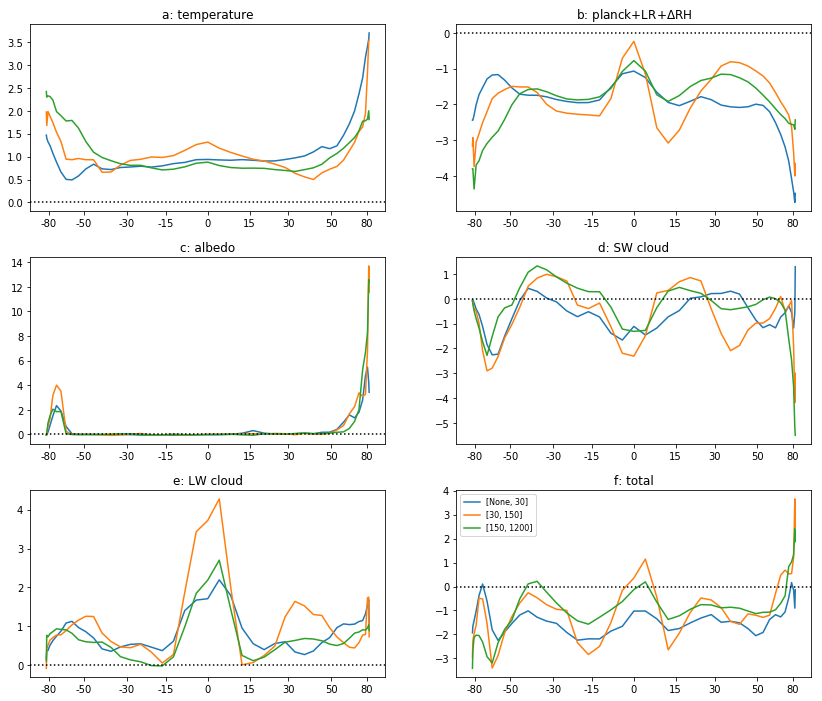

In [19]:
nvarx=['temperature','alllw','albedo','cloudsw','cloudlw','total']
# nvarx=['temperature','lwcs','swcs','crflw','crfsw','total']

if len(nvarx)//2 != len(nvarx)/2: nvarx.append('off')
fig=figure(figsize=(14,2*len(nvarx)))
plt.subplots_adjust(hspace=0.25)

panel=iter('abcdefghijkl')

for cnt,jj in enumerate(nvarx):
    
    ax1=fig.add_subplot(len(nvarx)//2,2,cnt+1)
    sca(ax1)

    for ii,tp in enumerate(timep):
        if jj == 'off': continue
        
        fdbk=z4xco2[jj].isel(time=slice(*tp))
        t1=ts.isel(time=slice(*tp))

        fdbk=slope(t1,fdbk)
        plotSinLat(fdbk,ax1,label=str(tp))
        if jj == 'total':
            print(tp,float(gavglat(fdbk)))

    axhline(0,color='k',ls='dotted')
    title('{}: {}'.format(next(panel),labels[jj]))
                
legend(fontsize=8);

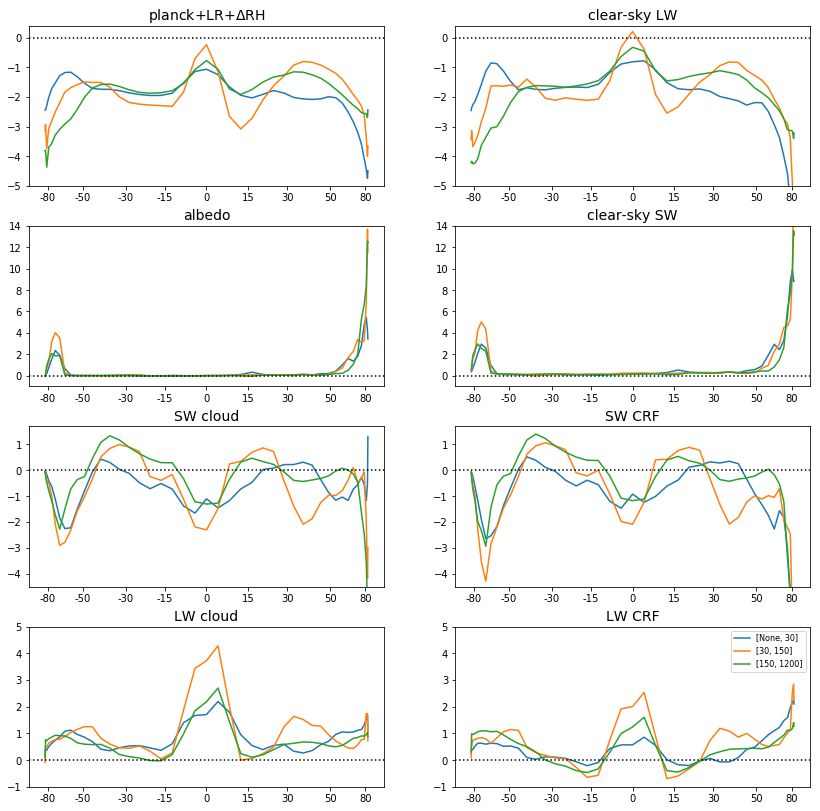

In [20]:
nvarx=['alllw','albedo','cloudsw','cloudlw']
nvarx2=['lwcs','swcs','crfsw','crflw']

fig=figure(figsize=(14,3.5*len(nvarx)))
plt.subplots_adjust(hspace=0.25)

panel=iter('abcdefghijkl')
rangex=[(-5,0.4),(-1,14),(-4.5,1.7),(-1,5)]

for cnt,(v1,v2) in enumerate(zip(nvarx,nvarx2)):
    
    for cnt2,vx in enumerate([v1,v2]):
        ax1=fig.add_subplot(len(nvarx),2,cnt*2+1+cnt2)
        sca(ax1)

        for ii,tp in enumerate(timep):

            fdbk=z4xco2[vx].isel(time=slice(*tp))
            t1=ts.isel(time=slice(*tp))

            fdbk=slope(t1,fdbk)
            plotSinLat(fdbk,ax1,label=str(tp))
        ylim(*rangex[cnt])
            
        axhline(0,color='k',ls='dotted')
        title('{}'.format(labels[vx]),fontsize=14)
                
legend(fontsize=8);

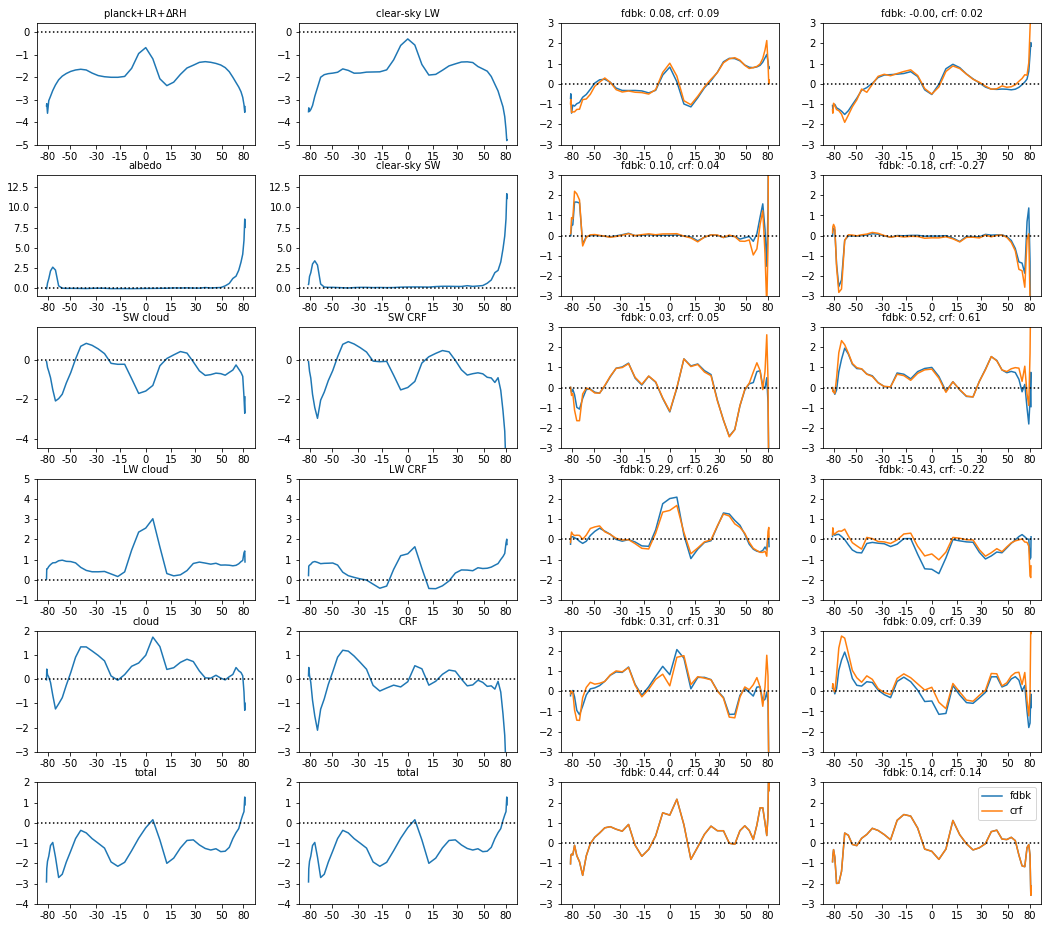

In [21]:
nvarx=['alllw','albedo','cloudsw','cloudlw','cloud','total']
nvarx2=['lwcs','swcs','crfsw','crflw','crf','total']

fig=figure(figsize=(18,2.7*len(nvarx)))
plt.subplots_adjust(hspace=0.25)

rangex=[(-5,0.4),(-1,14),(-4.5,1.7),(-1,5),(-3,2),(-4,2)]

for cnt,(v1,v2) in enumerate(zip(nvarx,nvarx2)):
    f1=[]
    for cnt2,vx in enumerate([v1,v2]):
        ax1=fig.add_subplot(len(nvarx),4,cnt*4+1+cnt2)
        sca(ax1)

        for ii,tp in enumerate(timep):

            fdbk=z4xco2[vx].isel(time=slice(*tp))
            t1=ts.isel(time=slice(*tp))

            fdbk=slope(t1,fdbk)
            f1.append(fdbk)
            # plotSinLat(fdbk,ax1,label=str(tp))

        plotSinLat((f1[-1]+f1[-2]+f1[-3])/3,ax1)
        ylim(*rangex[cnt])    
        axhline(0,color='k',ls='dotted')
        title(labels[vx],fontsize=10)

    for ii in [1,2]:
        ax1=fig.add_subplot(len(nvarx),4,cnt*4+2+ii)
        sca(ax1)
        
        d1=f1[ii]-f1[ii-1]
        d2=f1[ii+3]-f1[ii+3-1]

        plotSinLat(d1,ax1,label='fdbk')
        plotSinLat(d2,ax1,label='crf')
        axhline(0,color='k',ls='dotted')
        title('fdbk: {:.2f}, crf: {:.2f}'.format(float(gavglat(d1)),float(gavglat(d2))),fontsize=10)
        ylim(-3,3)


legend() 

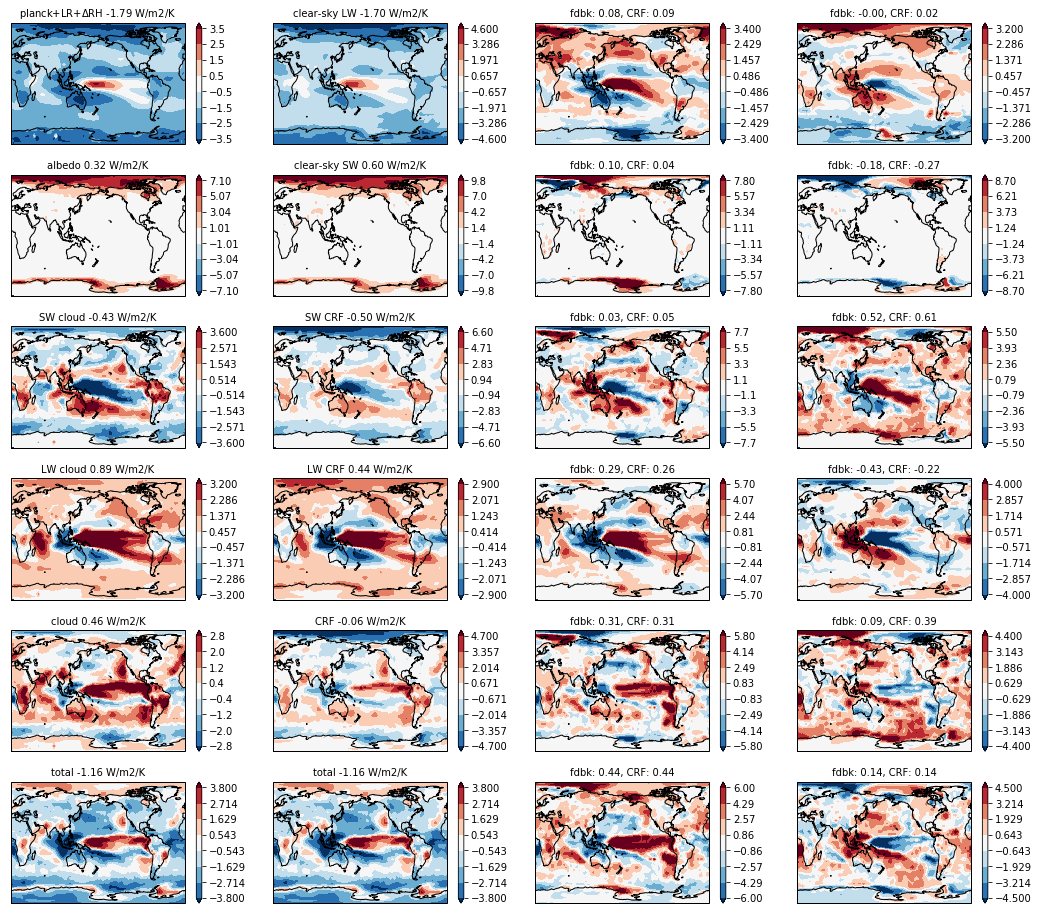

In [27]:
def plot2d(d11,axx,vmax=0):
    d11[0,0]=9e9
    d11[0,1]=-9e9
    
    if vmax == 0:
        ran=np.percentile(np.abs(d11),95)
    else:
        ran=vmax
        
    ran=np.round(ran,1)
#     ran=0.6
    n1=3
    n2=ran/(n1*2+1)
    lev1=(np.arange(n1+1))*(n2*2)+n2
    lev1=np.concatenate([-lev1[::-1],lev1])
    
    d11.plot.contourf(ax=axx,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r,levels=lev1)
    axx.coastlines()
    axx.set_aspect('auto', adjustable=None)


nvarx=['alllw','albedo','cloudsw','cloudlw','cloud','total']
nvarx2=['lwcs','swcs','crfsw','crflw','crf','total']

fig=figure(figsize=(18,2.7*len(nvarx)))
plt.subplots_adjust(hspace=0.25)

rangex=[(-5,0.4),(-1,14),(-4.5,1.7),(-1,5),(-3,2),(-4,2)]

for cnt,(v1,v2) in enumerate(zip(nvarx,nvarx2)):
    f1=[]
    for cnt2,vx in enumerate([v1,v2]):
        ax1=fig.add_subplot(len(nvarx),4,cnt*4+1+cnt2,projection=ccrs.PlateCarree(central_longitude=180))
        sca(ax1)

        for ii,tp in enumerate(timep):

            fdbk=a4xco2[vx].isel(time=slice(*tp))
            t1=ts.isel(time=slice(*tp))

            fdbk=slope(t1,fdbk)
            f1.append(fdbk)
            # plotSinLat(fdbk,ax1,label=str(tp))
        
        d1=(f1[-1]+f1[-2]+f1[-3])/3
        plot2d(d1,ax1)
        title('{} {:.2f} W/m2/K'.format(labels[vx],float(gavg(d1))),fontsize=10)

    for ii in [1,2]:
        ax1=fig.add_subplot(len(nvarx),4,cnt*4+2+ii,projection=ccrs.PlateCarree(central_longitude=180))
        sca(ax1)
        
        d1=f1[ii]-f1[ii-1]
        d2=f1[ii+3]-f1[ii+3-1]

        plot2d(d2,ax1)
        title('fdbk: {:.2f}, CRF: {:.2f}'.format(float(gavg(d1)),float(gavg(d2))),fontsize=10)

# legend() 

In [40]:
axes.shape

(3, 2)

crf -0.35118984231012346
crf -0.08471172934975925
crf 0.11131461111295084
crfsw -0.9235529785787003
crfsw -2.090065065178584
crfsw -1.1764803986619465
crflw 0.57236313605405
crflw 2.0053533271010813
crflw 1.287795011778773


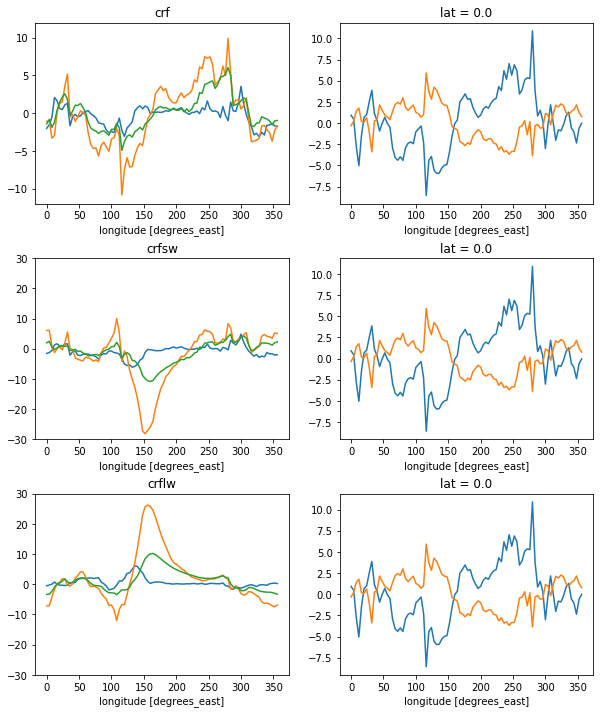

In [50]:
f1=[]
fig,axes=plt.subplots(3,2,figsize=(10,12))
plt.subplots_adjust(hspace=0.3)

for cnt,vx in enumerate('crf,crfsw,crflw'.split(',')):
    sca(axes[cnt,0])
    for ii,tp in enumerate(timep):

        fdbk=a4xco2[vx].isel(time=slice(*tp)).sel(lat=0)
        t1=ts.isel(time=slice(*tp))

        fdbk=slope(t1,fdbk)
        f1.append(fdbk)
        fdbk.plot()
        print(vx,float(fdbk.mean()))
    title(vx)

    if cnt == 0: ylim(-12,12)
    if cnt > 0: ylim(-30,30)

    sca(axes[cnt,1])
    (f1[1]-f1[0]).plot()
    (f1[2]-f1[1]).plot()

In [39]:
axes.shape

(3, 2)

In [31]:
fdbk

<xarray.DataArray (lon: 90)>
array([-2.607037, -2.089747, -1.095674,  1.419635,  1.056736,  0.190619,
        0.483033,  0.645068,  0.401663, -2.007537,  0.596109, -0.058266,
       -0.730068, -0.631039, -0.335128, -0.316948, -0.157012, -0.609259,
       -0.91211 , -1.324854, -1.99472 , -2.122137, -2.179428, -2.968764,
       -3.425822, -3.181898, -3.289034, -2.360138, -1.25965 , -2.791078,
       -3.363223, -1.920976, -1.323378, -0.557177,  1.178764,  1.62238 ,
        1.715049,  1.088641,  1.081577,  0.524208, -0.590451, -0.428179,
       -0.437539, -0.354927, -0.42519 , -0.464538, -0.459367, -0.672848,
       -0.547309, -0.374595, -0.595936, -0.503327, -0.371912, -0.808027,
       -1.043157, -1.264663, -1.038831, -0.995237, -0.83076 , -1.225462,
       -0.459448, -0.731179,  0.459405, -0.514727, -0.785768, -0.642712,
       -0.699563, -1.356903,  0.174227, -1.100191, -1.847485, -0.37964 ,
       -1.303025, -1.115369, -0.989082,  1.217302, -0.30487 , -1.335997,
       -1.964428, -2.7

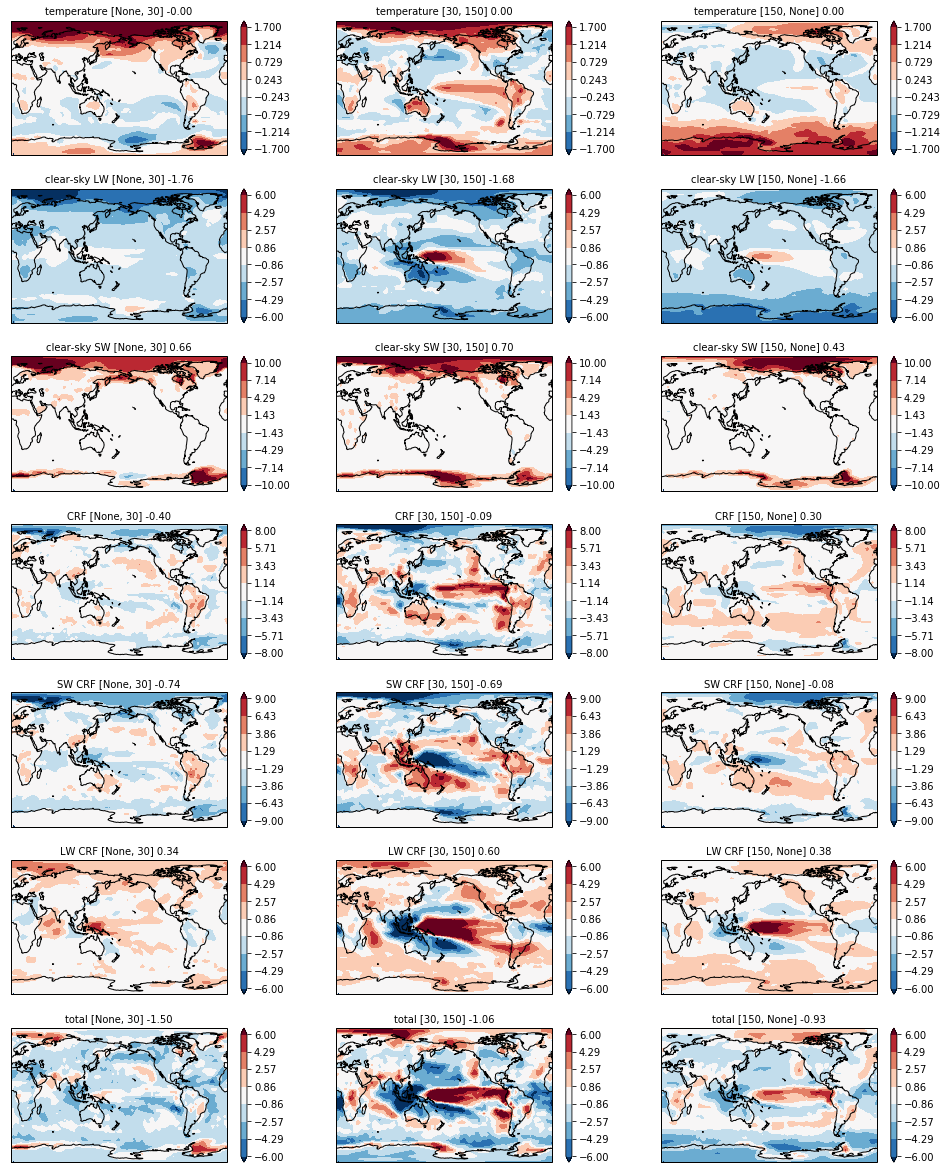

In [97]:
def plot2d(d11,axx,vmax=0):
    d11[0,0]=9e9
    d11[0,1]=-9e9
    
    if vmax == 0:
        ran=np.percentile(np.abs(d11),95)
    else:
        ran=vmax
        
    ran=np.round(ran,1)
#     ran=0.6
    n1=3
    n2=ran/(n1*2+1)
    lev1=(np.arange(n1+1))*(n2*2)+n2
    lev1=np.concatenate([-lev1[::-1],lev1])
    
    d11.plot.contourf(ax=axx,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r,levels=lev1)
    axx.coastlines()
    axx.set_aspect('auto', adjustable=None)

nvarx=['temperature','planckRH','lapserateRH','watervaporRH','albedo','cloud','cloudsw','cloudlw','total']
vmaxx=[3.4,6.4,2,3,9,5.3,7,6.4,6.6]

nvarx=['temperature','lwcs','swcs','crf','crfsw','crflw','total']
vmaxx=[1.7,6,10,8,9,6,6]
    
fig=figure(figsize=(5.5*len(timep),3*len(nvarx)))
plt.subplots_adjust(hspace=0.25)


for cnt,jj in enumerate(nvarx):
    
    for ii,tp in enumerate(timep):
        ax1=fig.add_subplot(len(nvarx),len(timep),cnt*len(timep)+ii+1,projection=ccrs.PlateCarree(central_longitude=180))
        sca(ax1)
        
        # get data over the 'timep' period
        fdbk=a4xco2[jj].isel(time=slice(*tp))
        t1=ts.isel(time=slice(*tp))

        # estimate the feedback as the linear regression of flux vs. Ts
        fdbk=slope(t1,fdbk)
        if jj == 'temperature': fdbk -= 1

        plot2d(fdbk,ax1,vmaxx[cnt])
        title('{} {} {:.2f}'.format(labels[jj],tp,float(gavg(fdbk))),fontsize=10)


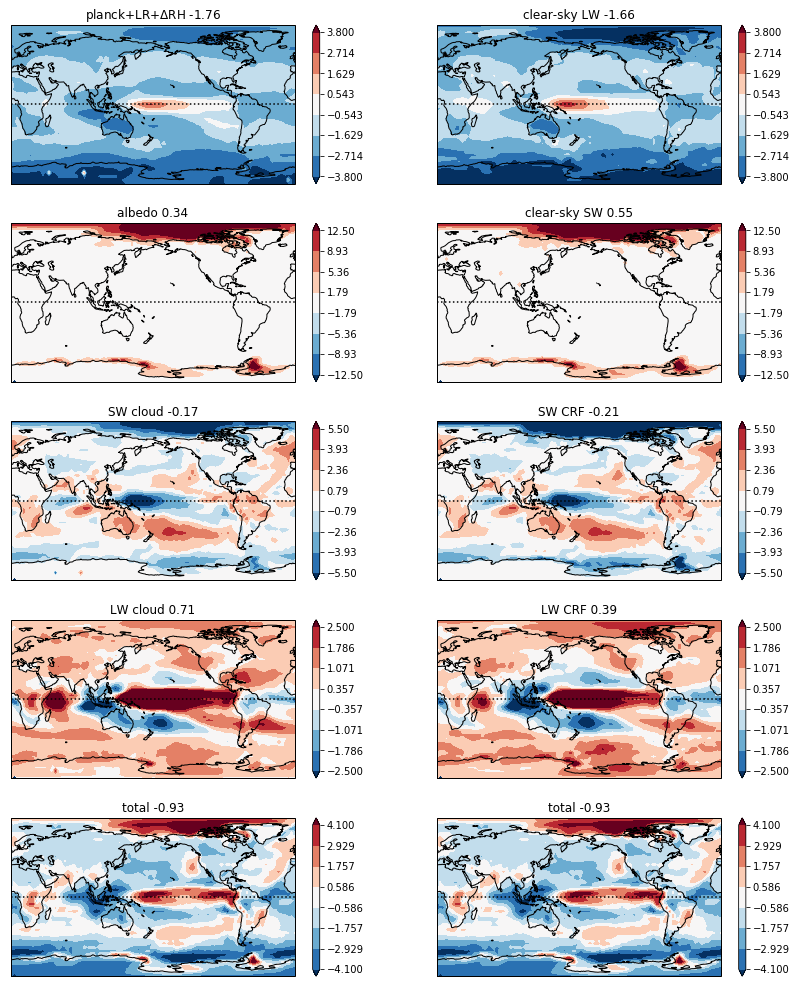

In [23]:
def plot2d(d11,axx,vmax=0):
    d11[0,0]=9e9
    d11[0,1]=-9e9
    
    if vmax == 0:
        ran=np.abs(np.percentile(np.abs(d11),95))
    else:
        ran=vmax

    ran=np.round(ran,1)

    n1=3
    n2=float(ran/(n1*2+1))

    lev1=(np.arange(n1+1))*(n2*2)+n2
    lev1=np.concatenate([-lev1[::-1],lev1])
    
    d11.plot.contourf(ax=axx,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r,levels=lev1)
    axx.coastlines()
    axx.set_aspect('auto', adjustable=None)
    return ran

nvarx=['alllw','albedo','cloudsw','cloudlw','total']
nvarx2=['lwcs','swcs','crfsw','crflw','total']

fig=figure(figsize=(14,3.5*len(nvarx)))
plt.subplots_adjust(hspace=0.25)

for cnt,(v1,v2) in enumerate(zip(nvarx,nvarx2)):
    vmaxx=0
    for cnt2,vx in enumerate([v1,v2]):
        ax1=fig.add_subplot(len(nvarx),2,cnt*2+1+cnt2,projection=ccrs.PlateCarree(central_longitude=180))
        sca(ax1)

        tp=(150,1200)
        fdbk=a4xco2[vx].isel(time=slice(*tp))
        t1=ts.isel(time=slice(*tp))

        fdbk=slope(t1,fdbk)
        vmaxx=plot2d(fdbk,ax1,vmaxx)
            
        axhline(0,color='k',ls='dotted')
        title('{} {:.2f}'.format(labels[vx],float(gavg(fdbk))));
            

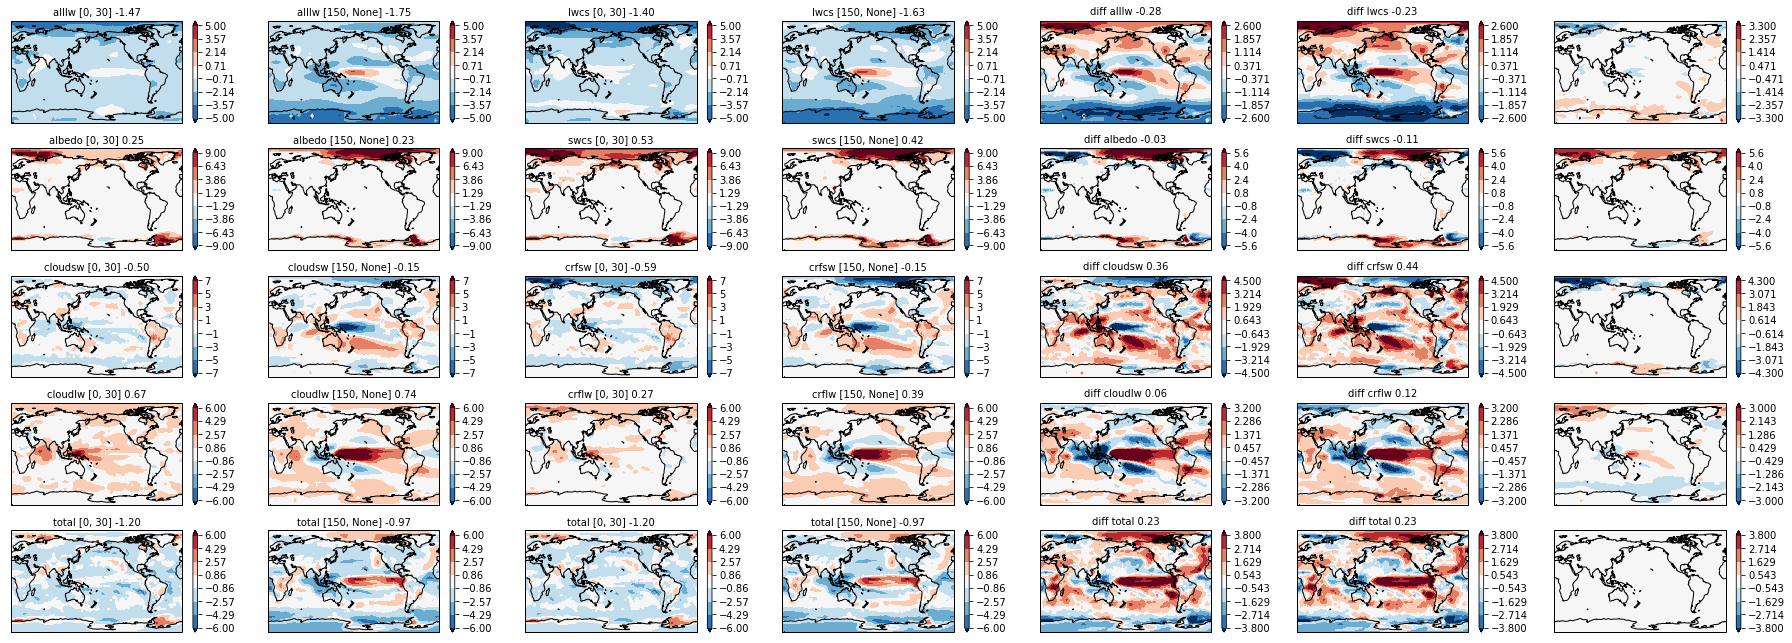

In [23]:
def plot2d(d11,axx,vmax=0):
    d11[0,0]=9e9
    d11[0,1]=-9e9
    
    if vmax == 0:
        ran=np.percentile(np.abs(d11),95)
    else:
        ran=vmax
    ran=np.round(ran,1)

    n1=3
    n2=ran/(n1*2+1)
    lev1=(np.arange(n1+1))*(n2*2)+n2
    lev1=np.concatenate([-lev1[::-1],lev1])
    
    d11.plot.contourf(ax=axx,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r,levels=lev1)
    axx.coastlines()
    axx.set_aspect('auto', adjustable=None)

nvarx=['alllw','albedo','cloudsw','cloudlw','total']
nvarx2=['lwcs','swcs','crfsw','crflw','total']
timep1=[[0,30],[150,None]]
vmaxx=[5,9,7,6,6]

nrows=len(nvarx)
ncols=(2*len(timep1)+3)
fig=figure(figsize=(4.5*ncols,2.25*nrows))
plt.subplots_adjust(hspace=0.25)

for cnt,(v1,v2) in enumerate(zip(nvarx,nvarx2)):
    f1=[];vm2=0
    for jj,vx in enumerate([v1,v2]):

        for ii,tp in enumerate(timep1):

            ax1=fig.add_subplot(nrows,ncols,cnt*ncols+1+jj*2+ii,projection=ccrs.PlateCarree(central_longitude=180))
            sca(ax1)

            # get data over the 'timep' period
            fdbk=a4xco2[vx].isel(time=slice(*tp))
            t1=ts.isel(time=slice(*tp))

            # estimate the feedback as the linear regression of flux vs. Ts
            fdbk=slope(t1,fdbk)
            f1.append(fdbk)

            plot2d(fdbk,ax1,vmaxx[cnt])
            title('{} {} {:.2f}'.format(vx,tp,float(gavg(fdbk))),fontsize=10)

    for ii,(fdbk,vx) in enumerate(zip([f1[1]-f1[0],f1[3]-f1[2]],[v1,v2])):
        ax1=fig.add_subplot(nrows,ncols,cnt*ncols+5+ii,projection=ccrs.PlateCarree(central_longitude=180))
        sca(ax1)

        plot2d(fdbk,ax1,vm2)
        title('diff {} {:.2f}'.format(vx,float(gavg(fdbk))),fontsize=10)
        vm2=np.percentile(np.abs(fdbk),95)

    ax1=fig.add_subplot(nrows,ncols,cnt*ncols+ncols,projection=ccrs.PlateCarree(central_longitude=180))
    plot2d((f1[1]-f1[0])-(f1[3]-f1[2]),ax1,vm2)
    
#     title('diff {} {} {:.2f}'.format(tx,vx,float(gavg(fdbk))),fontsize=10)

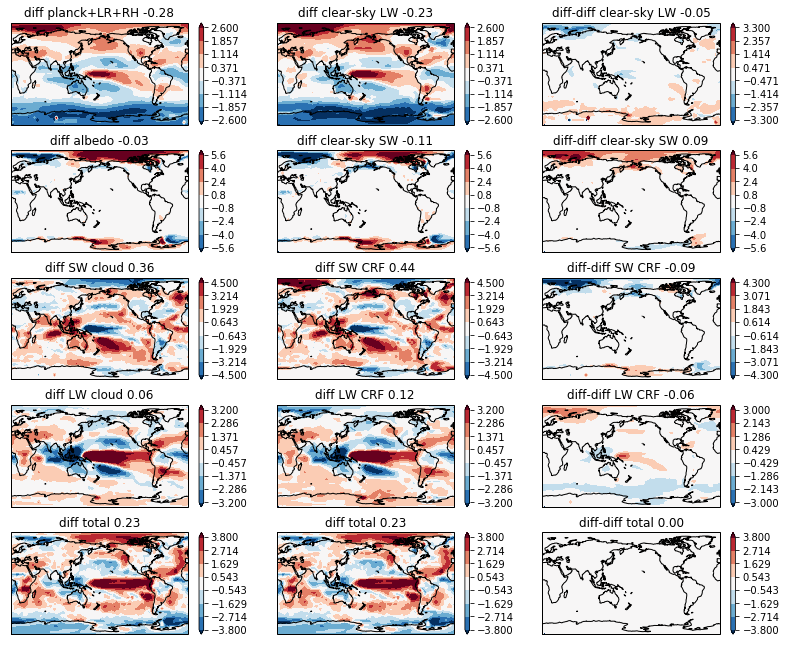

In [24]:
def plot2d(d11,axx,vmax=0):
    d11[0,0]=9e9
    d11[0,1]=-9e9
    
    if vmax == 0:
        ran=np.percentile(np.abs(d11),95)
    else:
        ran=vmax
    ran=np.round(ran,1)

    n1=3
    n2=ran/(n1*2+1)
    lev1=(np.arange(n1+1))*(n2*2)+n2
    lev1=np.concatenate([-lev1[::-1],lev1])
    
    d11.plot.contourf(ax=axx,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r,levels=lev1)
    axx.coastlines()
    axx.set_aspect('auto', adjustable=None)

nvarx=['alllw','albedo','cloudsw','cloudlw','total']
nvarx2=['lwcs','swcs','crfsw','crflw','total']
timep1=[[0,30],[150,None]]
vmaxx=[5,9,7,6,6]

nrows=len(nvarx)
ncols=3
fig=figure(figsize=(4.5*ncols,2.25*nrows))
plt.subplots_adjust(hspace=0.25)

for cnt,(v1,v2) in enumerate(zip(nvarx,nvarx2)):
    f1=[];vm2=0
    for jj,vx in enumerate([v1,v2]):

        for ii,tp in enumerate(timep1):

            # get data over the 'timep' period
            fdbk=a4xco2[vx].isel(time=slice(*tp))
            t1=ts.isel(time=slice(*tp))

            # estimate the feedback as the linear regression of flux vs. Ts
            fdbk=slope(t1,fdbk)
            f1.append(fdbk)

    for ii,(fdbk,vx) in enumerate(zip([f1[1]-f1[0],f1[3]-f1[2]],[v1,v2])):
        ax1=fig.add_subplot(nrows,ncols,cnt*ncols+ii+1,projection=ccrs.PlateCarree(central_longitude=180))
        sca(ax1)

        plot2d(fdbk,ax1,vm2)
        title('diff {} {:.2f}'.format(labels[vx],float(gavg(fdbk))),fontsize=12)
        vm2=np.percentile(np.abs(fdbk),95)

    ax1=fig.add_subplot(nrows,ncols,cnt*ncols+ncols,projection=ccrs.PlateCarree(central_longitude=180))
    difdif=(f1[1]-f1[0])-(f1[3]-f1[2])
    plot2d(difdif,ax1,vm2)
    
    title('diff-diff {} {:.2f}'.format(labels[vx],float(gavg(difdif))),fontsize=12)

In [79]:
eis=xr.open_dataarray('eis_4xCO2_annual.nc')
eis['time']=cftime.num2date(np.arange(len(eis.time))*360,'days since 1850-07-15',calendar='360_day')

eis

<xarray.DataArray 'EIS' (time: 2614, lat: 45, lon: 90)>
[10586700 values with dtype=float64]
Coordinates:
  * time     (time) object 1850-07-15 00:00:00 1851-07-15 00:00:00 ...
  * lon      (lon) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0 32.0 36.0 ...
  * lat      (lat) float64 -90.0 -85.91 -81.82 -77.73 -73.64 -69.55 -65.45 ...

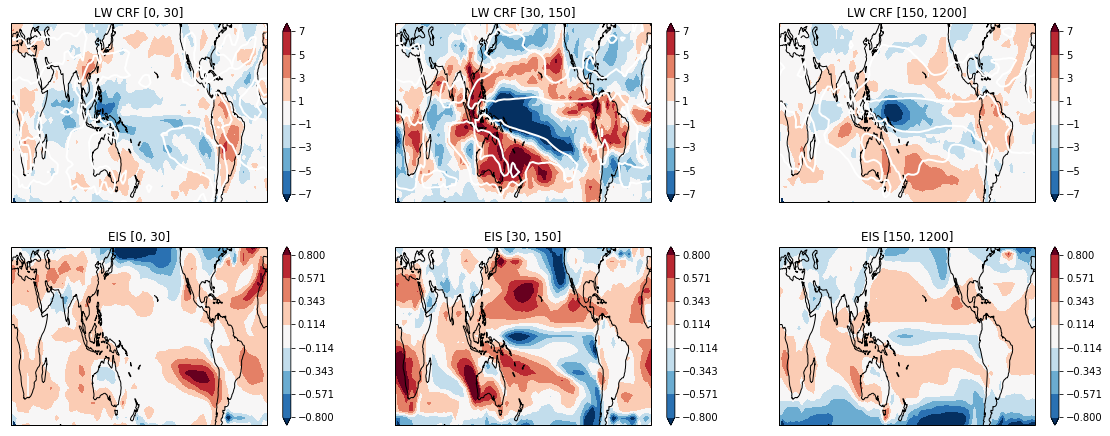

In [85]:
def plot2d(d11,axx,vmax=0):
    d11[0,0]=9e9
    d11[0,1]=-9e9
    
    if vmax == 0:
        ran=np.percentile(np.abs(d11),95)
    else:
        ran=vmax
    ran=np.round(ran,1)

    n1=3
    n2=ran/(n1*2+1)
    lev1=(np.arange(n1+1))*(n2*2)+n2
    lev1=np.concatenate([-lev1[::-1],lev1])
    
    d11.plot.contourf(ax=axx,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r,levels=lev1)
    axx.coastlines()
    axx.set_aspect('auto', adjustable=None)

timep1=[[0,30],[30,150],[150,1200]]
vmaxx=[7,0.8]

var1=[a4xco2.crfsw,eis]
nrows=len(var1)
ncols=len(timep1)
fig=figure(figsize=(6.5*ncols,3.7*nrows))
plt.subplots_adjust(hspace=0.25)
f1=[];a1=[]
for cnt,v1 in enumerate(var1):

        for ii,tp in enumerate(timep1):
            ax1=fig.add_subplot(nrows,ncols,cnt*ncols+ii+1,projection=ccrs.PlateCarree(central_longitude=180))
            a1.append(ax1) # store the axis
            
            # get data over the 'timep' period
            fdbk=v1.isel(time=slice(*tp))
            t1=ts.isel(time=slice(*tp))

            # estimate the feedback as the linear regression of flux vs. Ts
            f1.append(slope(t1,fdbk)) # store the regression pattern
            fdbk=slope(t1,fdbk)

            plot2d(fdbk.sel(lat=slice(-50,50)),ax1,vmaxx[cnt])

for ii in range(3):
    sca(a1[ii])
    f1[ii+3].plot.contour(levels=[[0.15,0.20,0.1][ii]],colors='w',linestyles='solid',linewidths=2,transform=ccrs.PlateCarree())

    a1[ii].set_title('LW CRF {}'.format(timep1[ii]),fontsize=12)
    a1[ii+3].set_title('EIS {}'.format(timep1[ii]),fontsize=12)

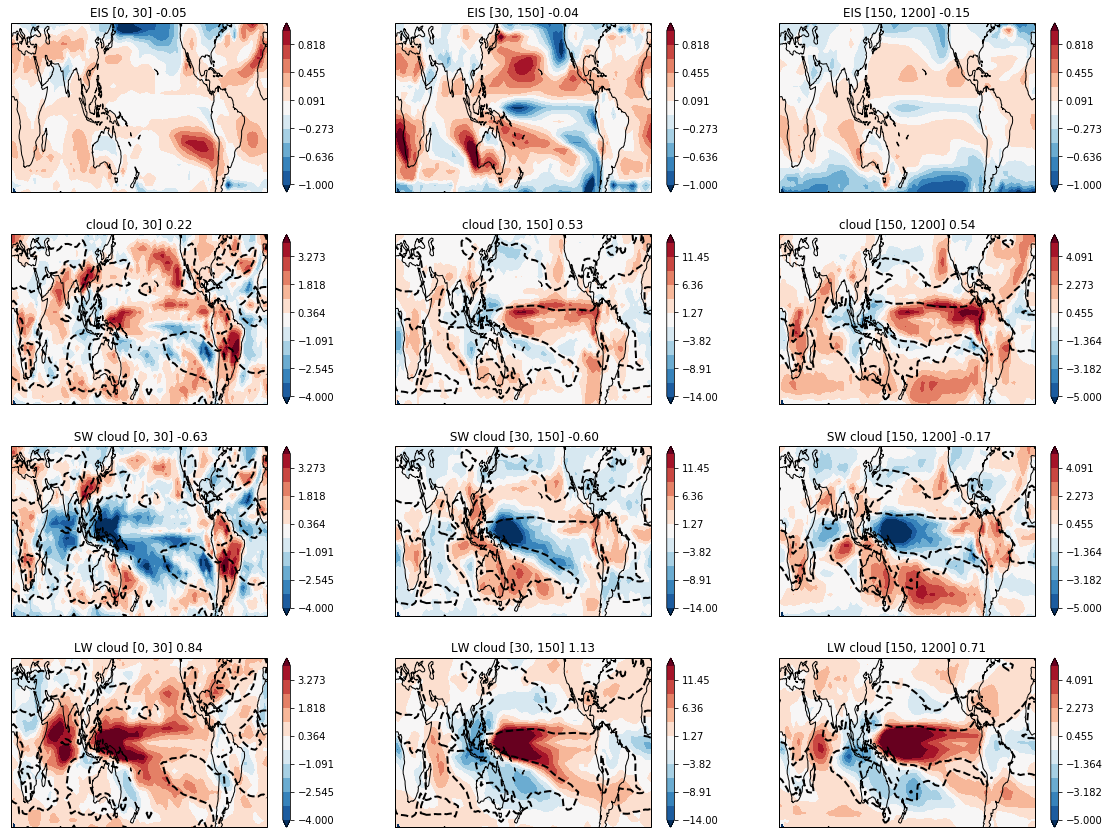

In [131]:
def plot2d(d11,axx,vmax=0):
    d11[0,0]=9e9
    d11[0,1]=-9e9
    
    if vmax == 0:
        ran=np.percentile(np.abs(d11),95)
    else:
        ran=vmax
    ran=np.round(ran,1)

    n1=5
    n2=ran/(n1*2+1)
    lev1=(np.arange(n1+1))*(n2*2)+n2
    lev1=np.concatenate([-lev1[::-1],lev1])
    
    d11.plot.contourf(ax=axx,transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r,levels=lev1)
    axx.coastlines()
    axx.set_aspect('auto', adjustable=None)

timep1=[[0,30],[30,150],[150,1200]]
vmaxx=[1,9,9,9]
xlab='EIS,cloud, SW cloud,LW cloud'.split(',')

var1=[eis,a4xco2.cloud,a4xco2.cloudsw,a4xco2.cloudlw]
nrows=len(var1)
ncols=len(timep1)
fig=figure(figsize=(6.5*ncols,3.7*nrows))
plt.subplots_adjust(hspace=0.25)
f1=[];a1=[]
for cnt,v1 in enumerate(var1):

        for ii,tp in enumerate(timep1):
            ax1=fig.add_subplot(nrows,ncols,cnt*ncols+ii+1,projection=ccrs.PlateCarree(central_longitude=180))
            a1.append(ax1) # store the axis
            
            # get data over the 'timep' period
            fdbk=v1.isel(time=slice(*tp))
            t1=ts.isel(time=slice(*tp))

            # estimate the feedback as the linear regression of flux vs. Ts
            f1.append(slope(t1,fdbk)) # store the regression pattern
            fdbk=slope(t1,fdbk)

            if cnt == 0: # set range of axis — variable vm
                vm = 1
            else:
                vm = [4,14,5][ii]
                
            plot2d(fdbk.sel(lat=slice(-50,50)),ax1,vm)
            
            if cnt != 0:
                f1[ii].plot.contour(levels=[0.15],colors='k',linestyles='dashed',linewidths=2,transform=ccrs.PlateCarree())

            title('{} {} {:.2f}'.format(xlab[cnt],tp,float(gavg(fdbk))))

